In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import qmnet_model as qnm
import qmnet_tools as qnt
import tensorflow as tf
import re
import numpy as np
import qmnet_layer as qnl

%matplotlib inline

In [71]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 128

In [3]:
molstr_list_HBe = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]
molstr_list_H2 = ['HH']

In [4]:
def get_inp_grp(molstr_list, resolution):
    inp_grp = []
    #inp_dump = []
    for molstr in molstr_list:
        if '+' in molstr:
            charge = 1
        elif '-' in molstr:
            charge = -1
        else:
            charge = 0
        alist = re.findall('[A-Z][a-z]*', molstr)
        Zs = [qtk.n2Z(a) for a in alist]
        inp_list = []
        inp_grp.append(inp_list)
        #inp_dump.append(inp_list)
        res = resolution
        for R in np.arange(0.3, 4.0 + res, res):
            mol = qtk.Molecule()
            ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
            mol.build(ZR)
            mol.charge = charge
            mol.name = mol.name + '_%s' % str(R)
            inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
            try:
                inp.run()
                D, U = np.linalg.eigh(inp.olp)
                inp.X = U / np.sqrt(D)

                # to save inps into pickle file
                #inp.delete_ht_types()
                #inp.delete_matrices()

                inp_list.append(inp)
            except:
                pass
        print "%s finished" % mol.name
    print [len(inp) for inp in inp_grp]
    return inp_grp

In [5]:
inp_grp_train = get_inp_grp(molstr_list_HBe, resolution=0.005)

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 577, 741, 741, 741, 741, 741, 740]


In [6]:
inp_grp_train[0][0].olp.shape

(10, 10)

In [7]:
#inp_grp_dense = get_inp_grp(molstr_list_HBe, resolution=0.0005)

In [73]:
inp_grp_H2 = get_inp_grp(molstr_list_H2, resolution=0.005)

H2_4.0 finished
[741]


In [94]:
inp_grp_H2_dense = get_inp_grp(molstr_list_H2, resolution=0.001)

H2_4.001 finished
[3702]


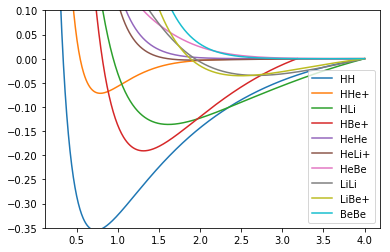

In [9]:
E_end = []
for i in range(len(inp_grp_train)):
    inp = inp_grp_train[i]
    E = np.array([o.Et for o in inp])
    E_end.append(E[-1])
    E = E-E[-1]
    R = [o.molecule.R[1,0] for o in inp]
    #print E
    plt.plot(R, E, label=molstr_list_HBe[i])
plt.ylim(-0.35, 0.1)
plt.legend()

In [95]:
reload(qnt)

# H2 model
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp_H2, 0, [0])
inp_dense, _, _ = qnt.train_test_valid(inp_grp_H2_dense, 0, [0])

In [10]:
reload(qnt)
# all molecules
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp_train, 2)
#inp_dense, _, _ = qnt.train_test_valid(inp_grp_dense, 2)
# print len(inp_train), len(inp_test), len(inp_valid)
I_train, Er_train, occ_train, nn_train, C_train, y_train = qnt.tfIO_batch(inp_train, batch_size)
I_test, Er_test, occ_test, nn_test, C_test, y_test = qnt.tfIO_batch(inp_test, batch_size)
I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = qnt.tfIO_batch(inp_valid, batch_size)

I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = qnt.tfIO(inp_valid, [1,3,5])

i_rep, i_min, i_mid, i_max = qnt.validation_inds(inp_valid)

print I_valid2.shape
print I_test[0].shape
print I_train[0].shape
print i_rep, i_min, i_mid, i_max
print len(I_train[0]), len(I_test[0]), len(I_valid[0])

inp_valid2 = [inp_valid[i] for i in [i_rep, i_min, i_mid, i_max]]

(3, 7, 10, 10)
(128, 7, 10, 10)
(128, 7, 10, 10)
131 263 501 740
128 128 128


In [181]:
model_file_name = 'A2_mseloss3.ckpt'
tf.reset_default_graph()
g = tf.Graph()

biases = []
weights = []

with g.as_default():
    y_prd, C_prd, param = qmnet_model(g, 4)
    #I, Er, occ, nn, keep_prob = param
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_file_name)
        variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        #print weights
        for v in variables:
            if 'weight' in v.name:
                weights.append(sess.run(v))
            elif 'bias' in v.name:
                biases.append(sess.run(v))

INFO:tensorflow:Restoring parameters from A2_mseloss3.ckpt


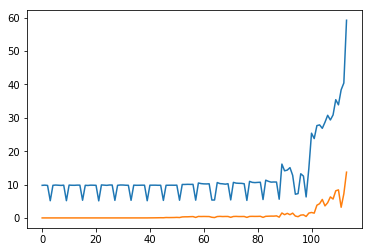

In [183]:
plt.plot([np.linalg.norm(w) for w in weights])
plt.plot([np.linalg.norm(w) for w in biases])

In [23]:
def get_C_prd(qmnet_model, model_file_name, inp_valid):
    I_list, Er_list, occ_list, nn_list, C_list, y_list = qnt.tfIO_batch(inp_valid, 100)
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
        y_prd, C_prd, param = qmnet_model(g, I_list[0][0].shape[-1])
        I, Er, occ, nn, keep_prob = param
        y_prd = qnl.HF_energy_layer(I, Er, occ, nn, C_prd)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, model_file_name)
            C_out_list, y_out_list = [], []
            for I_v, Er_v, occ_v, nn_v in zip(I_list, Er_list, occ_list, nn_list):
                valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, keep_prob:1.0}
                C_out, y_out = sess.run([C_prd, y_prd], feed_dict=valid_dict)
                C_out_list.extend(C_out)
                y_out_list.extend(y_out)
            return C_out_list, y_out_list

In [84]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

# qmnet_model = qnm.Ix0_dS5x5_O3x5
# model_root = 'H2_deep_test2'
# model_root = 'A2_deep_test'
# model_root = 'A2_maxmeanloss'
# model_root = 'A2_mseloss'
# model_root = 'A2_mse_reg2'

# qmnet_model = qnm.I3_S3O3x5d_S3O3x5_O3x3
# model_root = 'A2_mseloss2'

#qmnet_model = qnm.I3_S5x10_d_S5x5_dS2_O3x5
#model_root = 'A2_mseloss3'

#qm_model = qnm.Ix3_R5h1b_O0
#model_root = 'H2_rnn_test0'

# qm_model = qnm.Ix3_R5_O2
# model_root = 'H2_rnn_test1'

# qm_model = qnm.Ix3_R5h2b_O2
# model_root = 'A2_rnn_test0'

#qm_model = qnm.Ix3_R2h3b_R3h2b_R5h1b_O2
#qm_model = qnm.I2_R5h2b_R3h1b_O2
#model_root = 'H2_rnn_test3'
#model_root = 'A2_rnn_test4'
#model_root = 'A2_rnn_test5_large'
#model_root = 'A2_rnn_test4'

#qm_model = qnm.Fock_test
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I2_R5h2b_R3h1b_O2_Fock
#model_root = 'H2_fock_test0'

#qm_model = qnm.I2_R5h2b_R3h1b_O2
#qm_model = qnm.I2_R5h2b_d_R3h1b_d_R2h1b_O5
#model_root = 'A2_rnn_fock_test'
#model_root = 'H2_fock_test0'
#model_root = 'H2_p_test'
#model_root = 'A2_rnn_p_test'
#model_root = 'A2_rnn_p_test_back1/A2_rnn_p_test'

qm_model = qnm.I0_S1x2_d_S1x2_O1x3
model_root = 'H2_simple_test1'

model_file = "%s.ckpt" % model_root
model_hist = "%s_hist.pkl" % model_root

In [96]:
C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
C_prd_all, E_prd_all = get_C_prd(qm_model, model_file, inp_valid)
#C_prd2, E_prd2 = get_C_prd(qm_model, model_file, inp_valid2)
C_dense, E_dense = get_C_prd(qm_model, model_file, inp_dense)

# [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
opt_hist = qtk.load(model_hist)

print 'done'

INFO:tensorflow:Restoring parameters from H2_simple_test1.ckpt
INFO:tensorflow:Restoring parameters from H2_simple_test1.ckpt
INFO:tensorflow:Restoring parameters from H2_simple_test1.ckpt
INFO:tensorflow:Restoring parameters from H2_simple_test1.ckpt
done


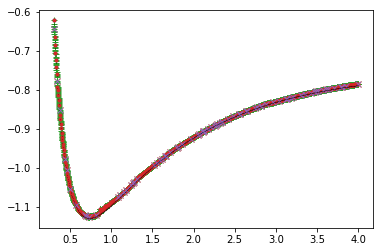

In [97]:
E_true = np.array([inp.Et for inp in inp_train]) 
#E_tar = np.array([inp.Et for inp in inp_train])
#E_tar = np.array([])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])
R_dense = np.array([inp.molecule.R[1,0] for inp in inp_dense])
# for i in range(len(molstr_list_HBe)):
#     print molstr_list_HBe[i], E_end[i]

plt.plot(R_tar, E_tar, ls='', marker='.')
plt.plot(R_prd, E_prd, ls='', marker='x')
plt.plot(R_dense, E_dense, ls='', marker='+')
plt.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
#plt.ylim(-28, -30)E_true = np.array([inp.Et for inp in inp_train]) 
#E_tar = np.array([inp.Et for inp in inp_train])
#E_tar = np.array([])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])
#R_dense = np.array([inp.molecule.R[1,0] for inp in inp_dense])
# for i in range(len(molstr_list_HBe)):
#     print molstr_list_HBe[i], E_end[i]

plt.plot(R_tar, E_tar, ls='', marker='.')
plt.plot(R_prd, E_prd, ls='', marker='x')
#plt.plot(R_dense, E_dense, ls='', marker='+')
plt.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
#plt.ylim(-28, -30)

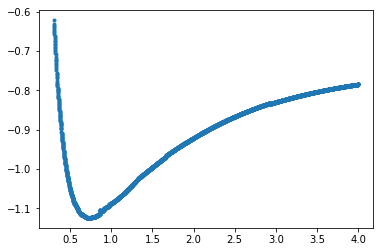

In [99]:
plt.plot(R_dense, E_dense, ls='', marker='.')

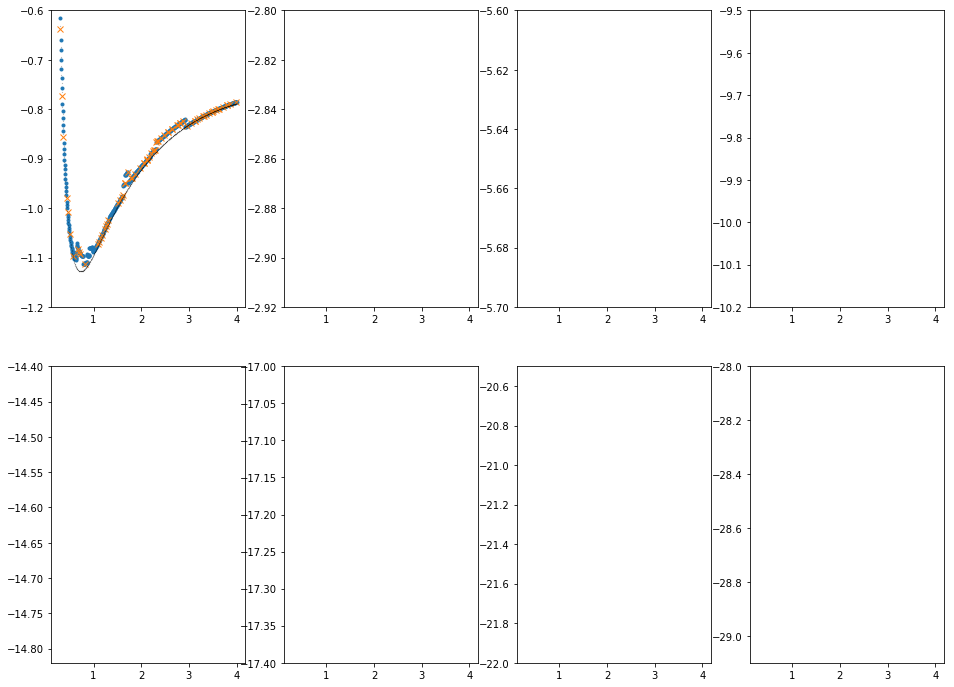

In [90]:
ylim_list = [
    [[-1.2, -0.6], 'H2'],
    [[-2.92, -2.8], 'HHe+'],
    [[-5.7, -5.6], 'HeHe'],
    [[-10.2, -9.5], 'HLi'],
    [[-14.82, -14.4], 'Li2, HBe+'], 
    [[-17.4, -17], 'HeBe'],
    [[-22, -20.5], 'LiBe+'],
    [[-29.1, -28], 'Be2'],
]

fig, axarr = plt.subplots(2, 4, figsize=(16,12))

for i in range(2):
    for j in range(4):
        s = j + i*4
        ax = axarr[i,j]
        ax.plot(R_tar, E_tar, ls='', marker='.')
        ax.plot(R_prd, E_prd, ls='', marker='x')
#         ax.plot(R_dense, E_dense, ls='', marker='+')
        ax.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
        ylim = ylim_list[s][0]
        ax.set_ylim(*ylim) # Be2

(-8, -7.5)

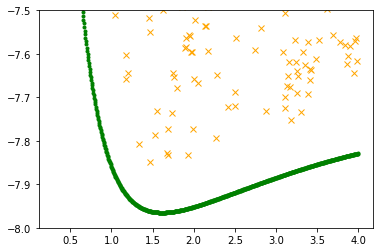

In [59]:
E_tar_all = np.array([inp.Et for inp in inp_valid])
R_all = np.array([inp.molecule.R[1,0] for inp in inp_valid])

plt.plot(R_all, E_tar_all, ls='', marker='.', color='g')
plt.plot(R_all, E_prd_all, ls='', marker='x', color='orange')
plt.ylim(-8,-7.5)

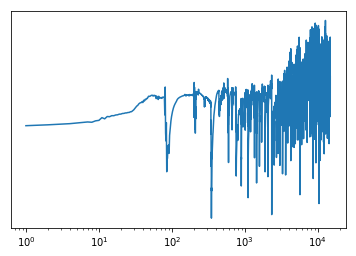

In [61]:
for i in [1]:
    plt.loglog(opt_hist[i])

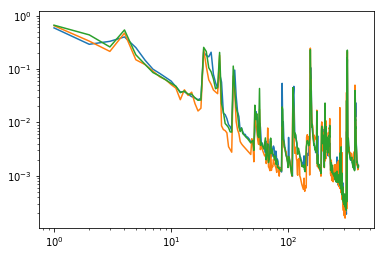

In [87]:
for i in [0,1,2]:
    plt.loglog(opt_hist[i])

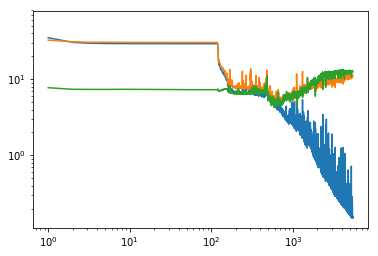

In [35]:
for i in [0,1,2]:
    plt.loglog(opt_hist[i])

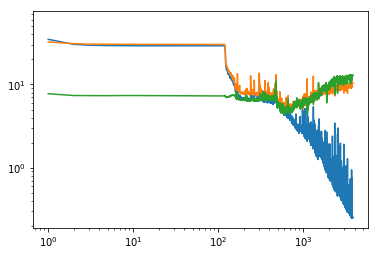

In [31]:
for i in [0,1,2]:
    plt.loglog(opt_hist[i])

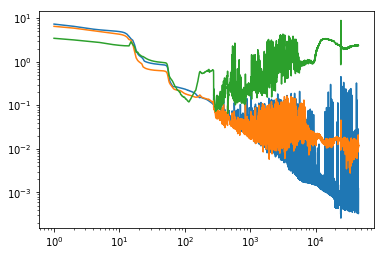

In [71]:
for i in [0,1,2]:
    plt.loglog(opt_hist[i])

In [53]:
C_prd_hist = np.asarray(opt_hist[-3])
print C_prd_hist.shape

(36999, 4, 4, 4)


In [54]:
def getE(inp, C=None):
    dm = inp.dm(C)
    J_kernel = np.tensordot(dm, inp.er, axes=([0,1], [0,2]))
    X_kernel = np.tensordot(dm, inp.er, axes=([0,1], [0,1]))
    
    Ek = np.trace(dm.dot(inp.kin)) * 2.
    Ev = np.trace(dm.dot(inp.v_ext)) * 2.
    Ej = np.trace(dm.dot(J_kernel)) * 2.
    Ex = np.trace(dm.dot(X_kernel)) * -1.
    nn = inp.ht_external['nn']
    
    return Ek + Ev + Ej + Ex + nn

In [55]:
for i in range(3):
    inp = inp_test[i]
    print inp,
    Ei_tar = getE(inp_test[i])
    Ei_prd = getE(inp_test[i], C_prd_hist[-1][i])
    print abs(Ei_tar - Ei_prd)


He2_3.255: horton 1.3978965698
H1He1_3.55: horton 2.27036885587
H1He1_3.225: horton 0.164040610635


In [56]:
errs_list = []
for h in range(len(C_prd_hist)):
    errs = []
    errs_list.append(errs)
    for i in range(len(inp_valid2)):
        Ch = C_prd_hist[h, i]
        errs.append(abs(getE(inp_valid2[i], Ch) - getE(inp_valid2[i])))
errs = np.array(errs_list).T

C_tar = []
for i in range(len(C_prd_hist[0])):
    C_tar.append(inp_valid2[i].mov)
C_tar = np.stack(C_tar)

In [57]:
C_tar.shape

(4, 4, 4)

In [58]:
for i in range(4):
    print getE(inp_valid2[i], C_tar[i]),
    print getE(inp_valid2[i], C_prd2[i]),
    print inp_valid2[i].Et

-7.82581131751 -7.72655462416 -7.82581131751
-7.95224494475 -7.65419959909 -7.95224494475
-7.89769828915 -7.76557996977 -7.89769828915
-7.84148489997 -7.78835594847 -7.84148489997


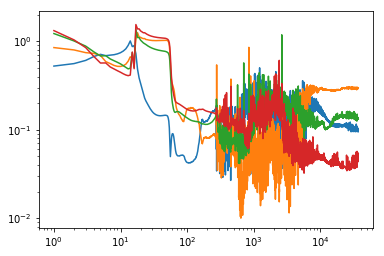

In [59]:
for i in range(4):
    plt.loglog(errs[i])